

**Dataset:** https://www.kaggle.com/tmdb/tmdb-movie-metadata


For this dataset, I will use regression techniques to predict a movie's rating based on different characteristics.

**Important Notes**

Use the "vote_average" column as the target.
Use regression techniques to predict the rating (vote_average) that a movie will receive based on different characteristics.
    

In [56]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

seed = 123

In [57]:
# Assuming the csv file and this ipynb are in the same local directory
df = pd.read_csv('tmdb_5000_movies.csv')

In [58]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [59]:
df.shape

(4803, 20)

In [60]:
df.id.nunique()

4803

The dataset contains 4803 movies and 20 features.  It presents a supervised regression problem, where the target variable is continuous.

### Data Cleaning

To evaluate the correlation, we'll select the numerical features only:

In [61]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [62]:
# To make the project simpler, will only use numerical features
numerical_df = df.select_dtypes(include = ['number']).copy()
numerical_df.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


Check for the missing values first:

In [63]:
numerical_df.isnull().sum()

budget          0
id              0
popularity      0
revenue         0
runtime         2
vote_average    0
vote_count      0
dtype: int64

In [64]:
# Calculate the mean of the "runtime" feature
mean_runtime = numerical_df['runtime'].mean()

# Impute the mean into the missing values in the "runtime" feature
numerical_df['runtime'].fillna(mean_runtime, inplace=True)

### Correlation Analysis

Correlation:

In [65]:
# Correlation matrix with absolute values only
numerical_df.corr().abs()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.089377,0.505414,0.730823,0.269834,0.093146,0.593180
id,0.089377,1.000000,0.031202,0.050425,0.153006,0.270595,0.004128
popularity,0.505414,0.031202,1.000000,0.644724,0.225481,0.273952,0.778130
revenue,0.730823,0.050425,0.644724,1.000000,0.251080,0.197150,0.781487
runtime,0.269834,0.153006,0.225481,0.251080,1.000000,0.373989,0.271927
vote_average,0.093146,0.270595,0.273952,0.197150,0.373989,1.000000,0.312997
vote_count,0.593180,0.004128,0.778130,0.781487,0.271927,0.312997,1.000000


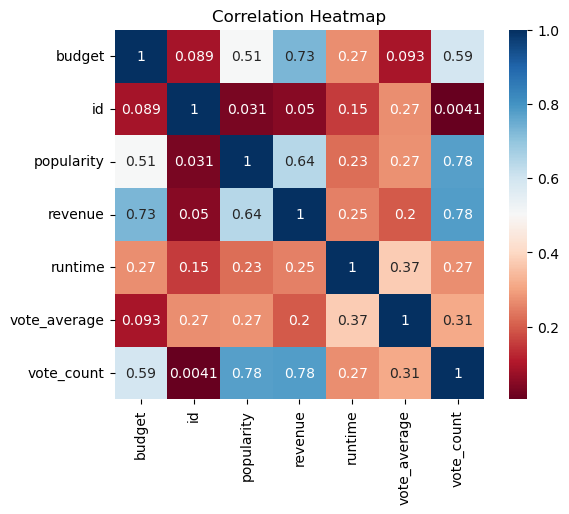

In [66]:
# Heatmap for better visualization
corr = numerical_df.corr().abs()

sns.heatmap(
    corr,
    annot=True,
    cmap = 'RdBu',
    square = True,
    annot_kws={"fontsize": 10}
)

plt.title('Correlation Heatmap')
plt.show()

We can identify variables that are not independent (highly correlated): with the highest correlation pairs being "popularity"-"vote_count" (0.778130), and "revenue"-"vote_count" (0.781487). This makes sense as popular movies are often those that receive a lot of votes, and high-revenue movies typically have higher visibility and attract more votes.

### Regression Models

In [67]:
# Split the data into features (X) and target variable (y)
X = numerical_df.drop(columns=['vote_average'])  # Features
y = numerical_df['vote_average']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to dataframes with column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize multiple regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor()
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model performance using Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error:", mse)
    print(f"{model_name} - R Squared:", r2)

Linear Regression - Mean Squared Error: 1.0526306135769758
Linear Regression - R Squared: 0.3018938141396065
Decision Tree Regression - Mean Squared Error: 1.0273673257023932
Decision Tree Regression - R Squared: 0.3186484641687245
Random Forest Regression - Mean Squared Error: 0.6012146815816856
Random Forest Regression - R Squared: 0.6012735304970596


We chose Mean Squared Error (MSE) and R-squared (R2) to evaluate our regression models for predicting "vote_average" in the movie dataset. MSE provides a clear measure of the average squared difference between predicted and actual values, emphasizing accuracy by penalizing larger errors. R2 indicates the proportion of variance in the target explained by the model, showing its goodness-of-fit. These metrics together give a comprehensive view of model performance and explanatory power.

Based on these results, the Random Forest Regression model appears to perform the best, as it has the lowest Mean Squared Error of 0.61 (indicating that, on average, the squared difference between the predicted and actual "vote_average" ratings is 0.60) and the highest R Squared of 0.59 (suggesting that approximately 60% of the variance in "vote_average" ratings is explained by the features in the random forest regression model). However, further analysis and hyperparamether tuning may be needed to confirm the optimal model.

**Linear Regression**

Let's create scatter plots of "vote_average" against each feature. This will allow us to visually inspect whether there's a linear relationship between target and its features:

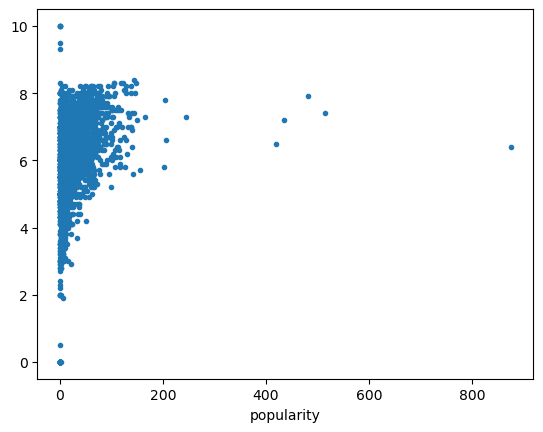

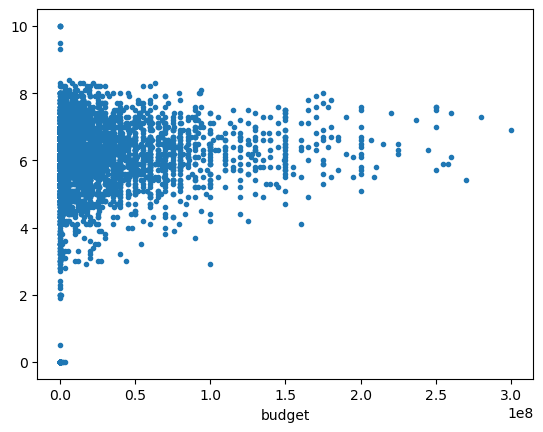

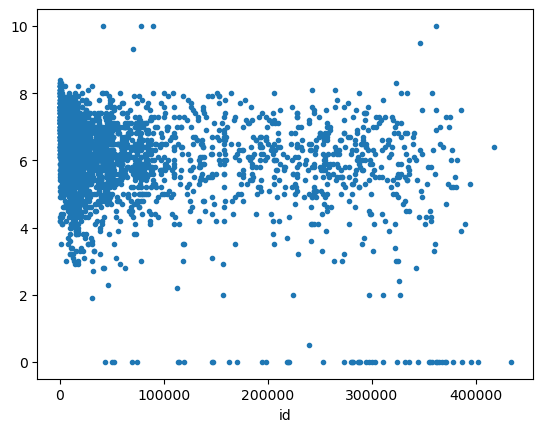

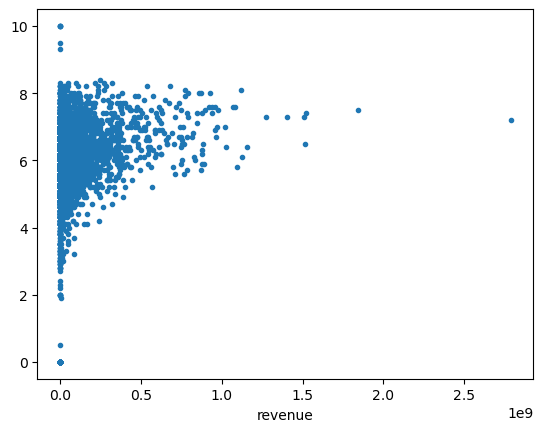

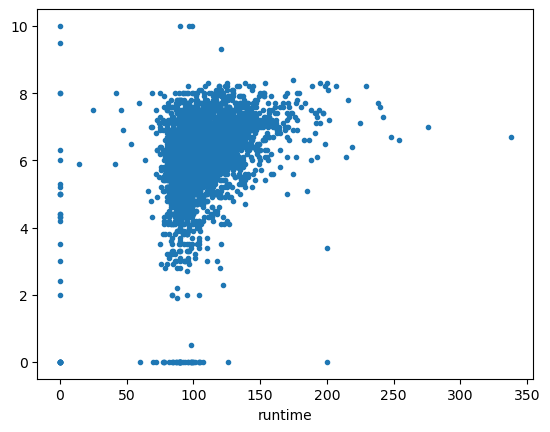

In [68]:
plt.plot(X_train["popularity"], y_train, '.')
plt.xlabel("popularity")
plt.show()


plt.plot(X_train["budget"], y_train, '.')
plt.xlabel("budget")
plt.show()

plt.plot(X_train["id"], y_train, '.')
plt.xlabel("id")
plt.show()


plt.plot(X_train["revenue"], y_train, '.')
plt.xlabel("revenue")
plt.show()

plt.plot(X_train["runtime"], y_train, '.')
plt.xlabel("runtime")
plt.show()


Given that the relationships are non-linear, we'll create a multiple non-linear regression function based on the polynomial features:

In [69]:

# Define polynomial features of degree 2
poly = PolynomialFeatures(degree = 2)

# Transform the training and test data to include polynomial features
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.transform(X_test_scaled)

# Convert the transformed arrays back to DataFrames with column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns=poly.get_feature_names_out(X_train_scaled.columns))
X_test_transformed = pd.DataFrame(X_test_transformed, columns=poly.get_feature_names_out(X_test_scaled.columns))

# Fit a linear regression model to the polynomial transformed training data
poly_model = LinearRegression().fit(X_train_transformed, y_train)

# Predict the target variable on the polynomial transformed test data
y_preds = poly_model.predict(X_test_transformed)

# Calculate the R-squared score to measure the goodness of fit of the model
r2 = r2_score(y_test, y_preds)

# Define a function to calculate the adjusted R-squared score.It penalizes overly complex models with many predictors.
# A higher adjusted R-squared value indicates a better fit while penalizing for model complexity.
def adjusted_r2(r2, X):
  return (1 - ((1 - r2)*(X.shape[0] - 1)/(X.shape[0] - X.shape[1] - 1)))

# Calculate the adjusted R-squared score for the model
adjusted_r2_result = adjusted_r2(r2_score(y_test, y_preds), X_train_scaled)

# Calculate the Mean Squared Error to measure the average squared difference between predicted and actual values
mse = mean_squared_error(y_test, y_preds)

print(f"Mean Squared Error:", mse)
print(f"R2 Score:", r2)
print(f"Adjusted R2 Score:", adjusted_r2_result)

Mean Squared Error: 0.9816065091214826
R2 Score: 0.3489971056704192
Adjusted R2 Score: 0.3479785874524328


The linear regression model's performance is suboptimal. Adding the polynomial hyperparamether improved slightly the performance, however, it still maintains a relatively high MSE of 0.98 and a modest R² score of 0.35. This suggests that the model explains only 35% of the variance in the target variable, indicating limited predictive power. Increasing the polynomial degree to 3 did not improve the model, resulting in a higher MSE and lower R² score. These findings suggest that the model is not effectively capturing the underlying relationships in the data, highlighting the need for alternative modeling approaches to achieve better predictive performance.

**Decision Trees**

1. No Hyperparamethers optimization:

In [70]:
# Fit a decision tree regressor to the scaled training data
clf = DecisionTreeRegressor(random_state = seed).fit(X_train_scaled, y_train)

y_preds = clf.predict(X_test_scaled)

r2 = r2_score(y_test, y_preds)

adjusted_r2_result = adjusted_r2(r2_score(y_test, y_preds), X_train_scaled)

mse = mean_squared_error(y_test, y_preds)

print(f"Mean Squared Error:", mse)
print(f"R2 Score:", r2)
print(f"Adjusted R2 Score:", adjusted_r2_result)

Mean Squared Error: 1.0462434963579605
R2 Score: 0.30612975976278967
Adjusted R2 Score: 0.3050441739892764


With Hyperparamethers Optimization:

In [71]:
# Define the parameters for grid search
parameters = {'max_depth': [4, 6, 10], 'min_samples_split': [2, 4, 10]}

# Initialize a decision tree regressor
clf_tree = DecisionTreeRegressor(random_state = seed)

# Perform grid search with cross-validation (cv=5) to find the best parameters
clf = GridSearchCV(clf_tree, parameters, cv = 5).fit(X_train_scaled, y_train)

# Predict the target variable on the scaled test data using the best model found by grid search
y_preds = clf.predict(X_test_scaled)

clf.best_params_

{'max_depth': 6, 'min_samples_split': 2}

In [72]:
r2 = r2_score(y_test, y_preds)

adjusted_r2_result = adjusted_r2(r2_score(y_test, y_preds), X_train_scaled)

mse = mean_squared_error(y_test, y_preds)

print(f"Mean Squared Error:", mse)
print(f"R2 Score:", r2)
print(f"Adjusted R2 Score:", adjusted_r2_result)

Mean Squared Error: 0.6800613195410715
R2 Score: 0.5489823231316402
Adjusted R2 Score: 0.5482766892173743



The decision tree regressor has shown significant improvement over the linear regression model. With a MSE of 0.68 and an R-squared (R²) score of 0.55, the decision tree model explains approximately 55% of the variance in the target variable, compared to only 35% explained by linear regression. The adjusted R-squared score, which accounts for model complexity, is also higher for the decision tree model at approximately 0.55, indicating a better fit.
This improvement can be attributed to the flexibility of decision trees in capturing non-linear relationships in the data.

Furthermore, the hyperparameter tuning has led to enhanced performance, as indicated by the reduced MSE and increased R² score compared to the initial results. However, it's noted that the decision tree model's performance is still slightly below that of the random forest model, suggesting that there might be further room for improvement with more sophisticated ensemble methods.

**Random Forest**

No Hyperparamethers Optimization:

In [73]:
rf = RandomForestRegressor(random_state = seed).fit(X_train_scaled, y_train)

y_preds = rf.predict(X_test_scaled)


r2 = r2_score(y_test, y_preds)

adjusted_r2_result = adjusted_r2(r2_score(y_test, y_preds), X_train_scaled)

mse = mean_squared_error(y_test, y_preds)

print(f"Mean Squared Error:", mse)
print(f"R2 Score:", r2)
print(f"Adjusted R2 Score:", adjusted_r2_result)


Mean Squared Error: 0.6059621394380853
R2 Score: 0.598125009397714
Adjusted R2 Score: 0.5974962610421433


With Hyperparamether Optimization:

In [74]:
# Define the parameter grid for tuning
parameters = {'n_estimators': [330, 340, 350, 360, 370]}

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=seed)

# Create a GridSearchCV object for hyperparameter tuning
clf = GridSearchCV(rf, parameters, cv=5)

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train)

# Get the best estimator found during grid search
best_estimator = clf.best_estimator_

# Make predictions on the test data using the best estimator
y_preds = best_estimator.predict(X_test)

r2 = r2_score(y_test, y_preds)

adjusted_r2_result = adjusted_r2(r2_score(y_test, y_preds), X_train_scaled)

mse = mean_squared_error(y_test, y_preds)

print(f"Mean Squared Error:", mse)
print(f"R2 Score:", r2)
print(f"Adjusted R2 Score:", adjusted_r2_result)


Mean Squared Error: 0.600664992503557
R2 Score: 0.6016380851098477
Adjusted R2 Score: 0.6010148330917666


In [75]:
# Through the Process of trial and error, figured the optimal number and applied it to the previous cell
clf.best_params_

{'n_estimators': 350}

The random forest model emerges as the most effective among the models evaluated so far, boasting an MSE of 0.60 and an impressive R-squared (R²) score of 0.60. These metrics signify that the model captures around 60% of the variance in the target variable, exhibiting superior predictive performance compared to both the linear regression and decision tree models. Moreover, the adjusted R-squared score reinforces this conclusion, standing at approximately 0.60. This suggests that the random forest model strikes an optimal balance between model complexity and predictive accuracy, making it the top-performing choice for predicting the "vote_average" in the movie dataset.

### Feature Importance:

In [76]:
print("col                    corr  pval")
for col in X.columns:
    if X[col].nunique() > 1:  # Check if column has more than one unique value
        corr, pval = scipy.stats.pearsonr(X[col], y)

    print(f"{col: <20}  {corr: >5.2f}  {pval:4.2f}")

col                    corr  pval
budget                 0.09  0.00
id                    -0.27  0.00
popularity             0.27  0.00
revenue                0.20  0.00
runtime                0.37  0.00
vote_count             0.31  0.00


Via Pearson correlation coefficient we can see that "runtime" and "vote_count" seem to be the largest contributing factors to a movies average rating (target "vote_average". With a p-value<0.05, we can conclude that these correlations are statistically significant.

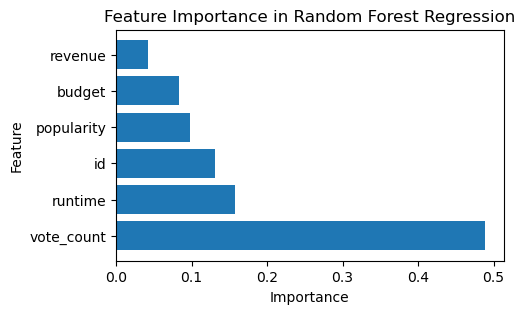

In [78]:
# Get feature importance through Random Forest Regression
feature_importance = models['Random Forest Regression'].feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regression')
plt.show()

Via Feature Importance, "vote_count" seems to be, by far, the most relevant feature meaning it has the highest influence.  
With "runtime" in second place and "popularity" in forth place.  
With both methods we conclude that "vote_count" and "runtime" have the largest impact on the movie rating.  

### Conclusion

I would recommend this model to the company for multiple reasons:

    1. Accuracy: It's an accurate model with a 0.6 score.
    2. Robustness to Overfitting: It's less prone to overfitting compared to individual decision trees.
    3. Handles Large Datasets: It can efficiently handle large datasets with a high number of features and samples. Even if the dataset used this time isn't large, It could handle even larger datasets.
    4. Feature Importance: Random Forest provides a built-in feature importance measure. It's easier to interpret ("White-box").
    5. Versatility: It can capture complex, nonlinear relationships between features and the target variable, making it suitable for a wide range of regression and classification tasks.
    6. Ease of use: It can effectively handle missing values and outliers without the need for preprocessing or imputation techniques. It can accommodate categorical features, numerical features, and mixed data types without requiring extensive data preparation.
    7. Reduced Bias: Random Forest tends to have lower bias compared to simpler models like linear regression, allowing it to capture more complex patterns and interactions in the data.
    8. Ensemble Learning: It's an ensemble learning method that combines the predictions of multiple weak learners (decision trees) to produce a strong learner. This ensemble approach often leads to more stable and accurate predictions than individual models.

    Overall It's an efficient model that has practical use for companies